# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

# Extract cell activity and trial variables from simulation results

In [2]:
# Initialize arrays of interest variables 
# NOTE: each neuron's activity is a row; column index is trial number

N_PFC_NEURONS = 500
N_MD_NEURONS = 2
N_OUTPUT_NEURONS = 2
TRIAL_TIME = 200

s_trial = 0
t_trial = 4800
n_trials = t_trial - s_trial

rPFC_trials = np.zeros((n_trials, TRIAL_TIME, N_PFC_NEURONS))
task_input = np.zeros((2, n_trials))

# Extract the data

data_dir = "/om2/group/halassa/PFCMD-ali-sabrina/020321_qvals/by_trial"

for i in range(s_trial, t_trial):
    with open(data_dir + "/" + str(i) + ".json") as json_file:
        data = json.load(json_file)
        idx = i - s_trial
                
        rPFC = np.array(data["network_rates"]["r_PFC"])
        rPFC_trials[idx,:,:] = rPFC
        
        trial_task_input = np.array(data["trial_data"]["input"])
        task_input[:,idx] = trial_task_input[:2]


FileNotFoundError: [Errno 2] No such file or directory: '/om2/group/halassa/PFCMD-ali-sabrina/020321_qvals/by_trial/0.json'

# Compute logistic regression seudo p-squared values for all PFC neurons

## 1. Get an equal number of trials per association levels 
Note the association levels are:
`[.90, .10, .90, .70, .90, .10, .70, .30, .90, .50, .90, .10]`

We will get 50 trials from .90, .70, .30 and .10, and we will get 100 trials from .50.
We only consider trials in the second half of the association level, when learning is finished and activity is more likely to be stable.

/home/ali/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ali/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/ali/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ali/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ali/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


FileNotFoundError: [Errno 2] No such file or directory: '/om2/group/halassa/PFCMD-ali-sabrina/030821_input-like/nidx=0.jpg'

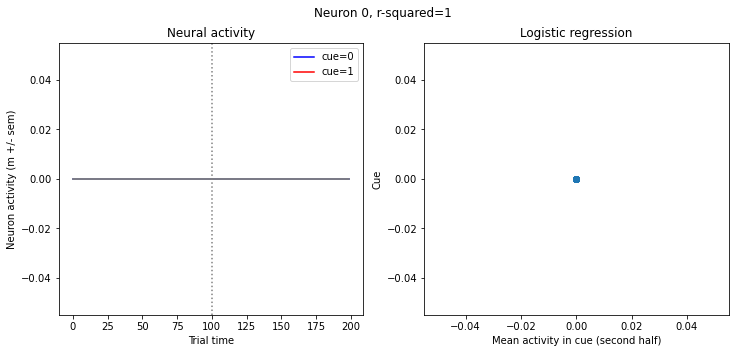

In [3]:
SAVE_DIR = '/om2/group/halassa/PFCMD-ali-sabrina/030821_input-like'

def plot_stderr(ax, x, c, l):
    m = np.mean(x, 0)
    stderr = stats.sem(x, 0)
    ax.plot(m, c, label=l)
    ax.plot(m + stderr, 'grey')
    ax.plot(m - stderr, 'grey')

# N_PFC_NEURONS = 500
CUE_TIME = 100

alevel_90_idxs = [0, 2, 4, 8, 10]
alevel_10_idxs = [1, 5, 11]
alevel_70_idxs = [3, 6]
alevel_30_idxs = [7]
alevel_50_idxs = [9]

def sample_trials(alevel_idxs, n_samples):
    trial_per_alevel = 400
    trials_offset = 200 # Only consider the second half of the alevel
    
    trials_to_sample = []
    for n_bin in alevel_idxs:
        trial_s = n_bin * trial_per_alevel + trials_offset
        trial_t = (n_bin + 1) * 400
        trials_to_sample = trials_to_sample + list(range(trial_s, trial_t))
    return random.sample(trials_to_sample, n_samples)
    
prsquareds = []    
for neuron_idx in range(N_PFC_NEURONS):
    
    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented
    
    alevel_90_trials = sample_trials(alevel_90_idxs, 100)
    alevel_10_trials = sample_trials(alevel_10_idxs, 100)
    alevel_70_trials = sample_trials(alevel_70_idxs, 100)
    alevel_30_trials = sample_trials(alevel_30_idxs, 100)
    alevel_50_trials = sample_trials(alevel_50_idxs, 200)
    trials = alevel_90_trials + alevel_10_trials + alevel_70_trials + alevel_30_trials + alevel_50_trials

    # Get cue 1 value and neuron activity for each trial
    # Only consider the activity over the second half of the cue period
    
    cuetime_s = math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = CUE_TIME
    
    cue = task_input[0, trials]
    neuron_activity = np.mean(rPFC_trials[trials, cuetime_s:cuetime_t, neuron_idx],1)
        
    # Run logistic regression
    try:
        X = np.transpose([np.ones(len(neuron_activity)), neuron_activity])
        y = cue
        model_fit = sm.Logit(y,X).fit(maxiter=50)
        prsquareds.append(model_fit.prsquared)
    except np.linalg.LinAlgError:
        prsquareds.append(0)
    except sm.tools.sm_exceptions.PerfectSeparationError:
        prsquareds.append(1) # Data is linearly separable
        
    if prsquareds[neuron_idx] >= 0.95:
        fig = plt.figure(figsize=(12,5))

        ax1 = fig.add_subplot(1, 2, 1)
        plot_stderr(ax1, rPFC_trials[trials, :, neuron_idx][cue == 0], 'b', 'cue=0')
        plot_stderr(ax1, rPFC_trials[trials, :, neuron_idx][cue == 1], 'r', 'cue=1')
        ax1.axvline(CUE_TIME, color='grey', linestyle=':')
        ax1.legend()
        ax1.set_title(f"Neural activity")
        ax1.set_xlabel("Trial time")
        ax1.set_ylabel("Neuron activity (m +/- sem)")

        ax2 = fig.add_subplot(1, 2, 2)
        ax2.scatter(neuron_activity, cue)
        if prsquareds[neuron_idx] < 1:
            points = sorted(zip(neuron_activity, model_fit.predict(X)) , key=lambda k: [k[1], k[0]])
            points_x, points_y = map(list, zip(*points))
            ax2.plot(points_x, points_y, 'k')
        ax2.set_xlabel("Mean activity in cue (second half)")
        ax2.set_ylabel("Cue")
        ax2.set_title("Logistic regression")
        fig.suptitle(f"Neuron {neuron_idx}, r-squared={prsquareds[neuron_idx]}")
        plt.savefig(f"{SAVE_DIR}/nidx={neuron_idx}.jpg", transparent=False)
        plt.close()

# Replace any -Inf wth 0
np.where(prsquareds == float("-inf"), 0, prsquareds)

# Plot distribution of pseudo r-squared values
plt.hist(prsquareds, bins=50)
plt.title("PFC neurons logistic regression r-squared values")
plt.xlabel("R^2 (cue vs neural activity)")
plt.ylabel("Number of neurons")
plt.savefig(f"{SAVE_DIR}/regression-histogram.jpg", transparent=False)
plt.close()

ValueError: supplied range of [-inf, 1.0] is not finite

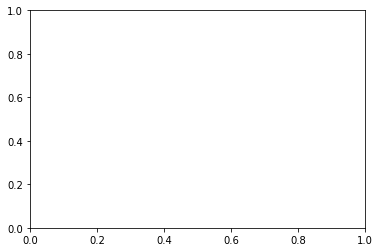